# Traffic Sign Recognition (GTSRB) — Low RAM Edition

**Objective:** Classify traffic signs into 43 classes using deep learning (CNN).

**⚡ Optimized for devices with limited RAM (4-8 GB)**

**Topics Covered:**
- Computer Vision (CNN) / Multi-class Classification
- Image preprocessing (resize, normalize)
- Data augmentation
- Lightweight Custom CNN vs. MobileNetV2 (α=0.35)
- Memory-efficient training techniques
- Evaluation: accuracy, confusion matrix

**Tools:** Python, TensorFlow/Keras, OpenCV, scikit-learn

**Low RAM Features:**
- Batch size: 16 (reduced from 64)
- Chunked data loading
- Lightweight model architectures
- Aggressive garbage collection

## 1. Imports & Configuration

In [2]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import backend as K

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")

# Memory optimization for TensorFlow
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Paths
DATA_DIR = os.path.join(os.getcwd(), '/root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1')
TRAIN_CSV = os.path.join(DATA_DIR, 'Train.csv')
TEST_CSV  = os.path.join(DATA_DIR, 'Test.csv')
META_CSV  = os.path.join(DATA_DIR, 'Meta.csv')

# === LOW RAM CONFIGURATION ===
IMG_SIZE = 32          # Keep at 32x32 for memory efficiency
NUM_CLASSES = 43
BATCH_SIZE = 16        # Reduced from 64 for low RAM
EPOCHS = 15            # Slightly reduced
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

def clear_memory():
    """Utility to free up RAM."""
    K.clear_session()
    gc.collect()

print("✓ Low RAM mode enabled")

TensorFlow version: 2.19.0
GPU available: True
✓ Low RAM mode enabled


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download(
    "meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)


100%|██████████| 612M/612M [00:06<00:00, 99.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign/versions/1


## 2. Load & Explore the Dataset

In [3]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)
meta_df  = pd.read_csv(META_CSV)

print(f"Training samples : {len(train_df)}")
print(f"Test samples     : {len(test_df)}")
print(f"Number of classes: {train_df['ClassId'].nunique()}")
print()
train_df.head()

Training samples : 39209
Test samples     : 12630
Number of classes: 43



,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


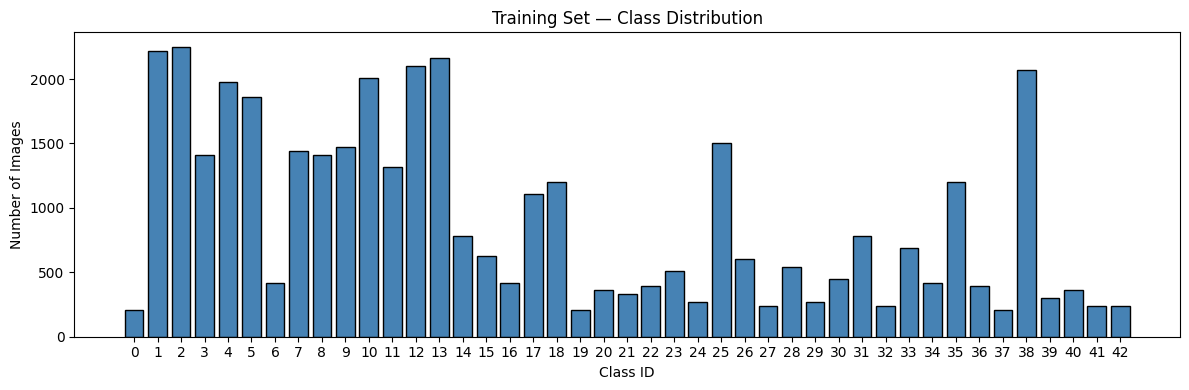

Min samples per class: 210 (class 0)
Max samples per class: 2250 (class 2)


In [4]:
# Class distribution
fig, ax = plt.subplots(figsize=(12, 4))  # Slightly smaller
class_counts = train_df['ClassId'].value_counts().sort_index()
ax.bar(class_counts.index, class_counts.values, color='steelblue', edgecolor='black')
ax.set_xlabel('Class ID')
ax.set_ylabel('Number of Images')
ax.set_title('Training Set — Class Distribution')
ax.set_xticks(range(NUM_CLASSES))
plt.tight_layout()
plt.show()
plt.close()

print(f"Min samples per class: {class_counts.min()} (class {class_counts.idxmin()})")
print(f"Max samples per class: {class_counts.max()} (class {class_counts.idxmax()})")

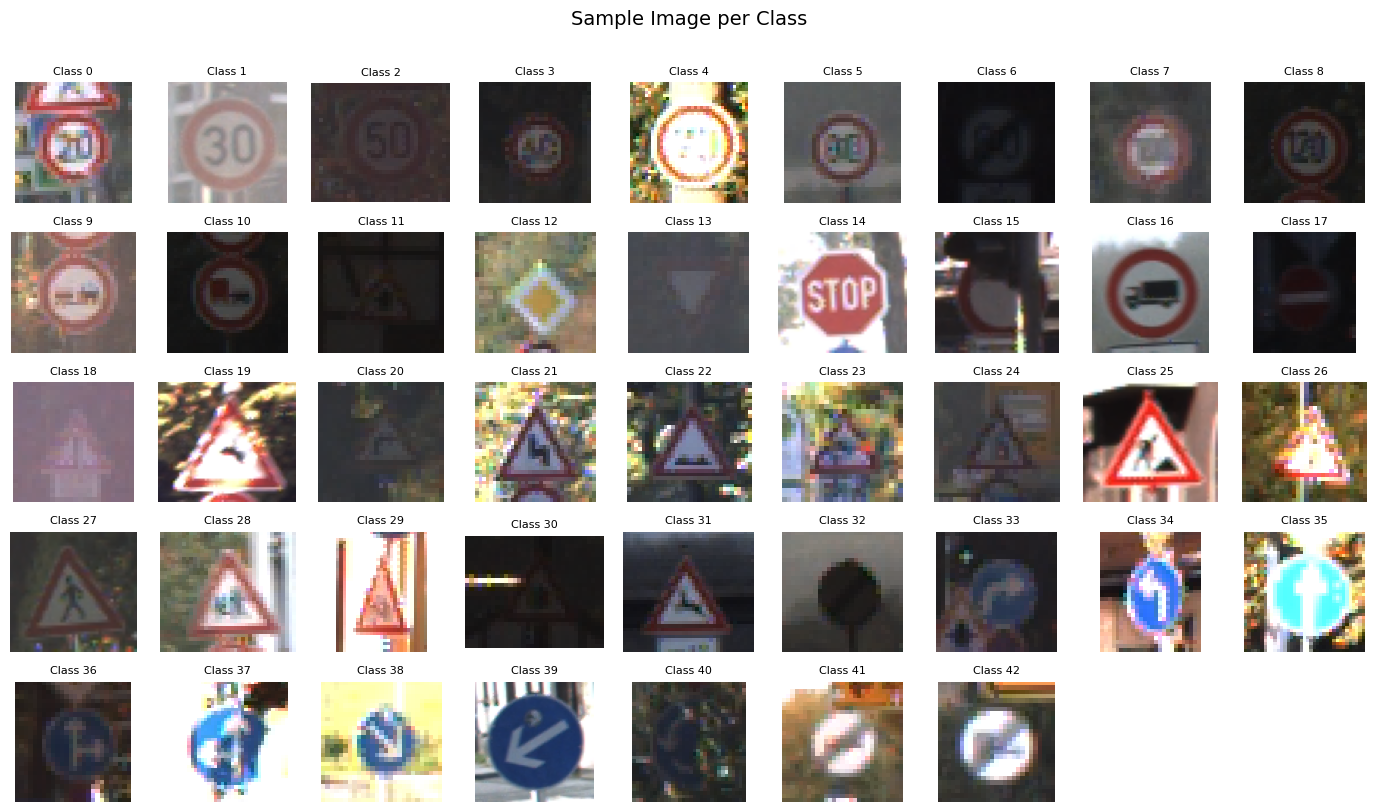

75

In [5]:
# Visualise one sample per class (memory-efficient)
fig, axes = plt.subplots(5, 9, figsize=(14, 8))  # Slightly smaller
axes = axes.flatten()

for class_id in range(NUM_CLASSES):
    sample = train_df[train_df['ClassId'] == class_id].iloc[0]
    img_path = os.path.join(DATA_DIR, sample['Path'])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[class_id].imshow(img)
    axes[class_id].set_title(f'Class {class_id}', fontsize=8)
    axes[class_id].axis('off')

# Hide unused subplots
for i in range(NUM_CLASSES, len(axes)):
    axes[i].axis('off')

plt.suptitle('Sample Image per Class', fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

# Clean up
plt.close()
gc.collect()

## 3. Image Preprocessing — Resize & Normalize

In [6]:
def load_images_in_chunks(df, data_dir, img_size=IMG_SIZE, chunk_size=5000):
    """Load images in chunks to reduce peak memory usage."""
    all_images = []
    all_labels = []

    total = len(df)
    for start_idx in range(0, total, chunk_size):
        end_idx = min(start_idx + chunk_size, total)
        chunk_df = df.iloc[start_idx:end_idx]

        images = []
        labels = []
        for _, row in chunk_df.iterrows():
            img_path = os.path.join(data_dir, row['Path'])
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(row['ClassId'])

        all_images.extend(images)
        all_labels.extend(labels)

        # Clear chunk memory
        del images, labels
        gc.collect()

        print(f"  Loaded {end_idx}/{total} images...")

    # Convert to numpy with memory-efficient dtype
    images_array = np.array(all_images, dtype='float32') / 255.0
    del all_images
    gc.collect()

    return images_array, np.array(all_labels)

print("Loading training images (chunked for low RAM)...")
X_full, y_full = load_images_in_chunks(train_df, DATA_DIR)
print(f"  Loaded {X_full.shape[0]} images — shape: {X_full.shape[1:]}")
gc.collect()

print("Loading test images (chunked for low RAM)...")
X_test, y_test = load_images_in_chunks(test_df, DATA_DIR)
print(f"  Loaded {X_test.shape[0]} images — shape: {X_test.shape[1:]}")
gc.collect()

Loading training images (chunked for low RAM)...
  Loaded 5000/39209 images...
  Loaded 10000/39209 images...
  Loaded 15000/39209 images...
  Loaded 20000/39209 images...
  Loaded 25000/39209 images...
  Loaded 30000/39209 images...
  Loaded 35000/39209 images...
  Loaded 39209/39209 images...
  Loaded 39209 images — shape: (32, 32, 3)
Loading test images (chunked for low RAM)...
  Loaded 5000/12630 images...
  Loaded 10000/12630 images...
  Loaded 12630/12630 images...
  Loaded 12630 images — shape: (32, 32, 3)


0

In [7]:
# Train / Validation split (80 / 20)
X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.2, random_state=SEED, stratify=y_full
)

# Free memory from full dataset
del X_full, y_full
gc.collect()

# One-hot encode labels
y_train_cat = to_categorical(y_train, NUM_CLASSES)
y_val_cat   = to_categorical(y_val,   NUM_CLASSES)
y_test_cat  = to_categorical(y_test,  NUM_CLASSES)

print(f"Train : {X_train.shape[0]}")
print(f"Val   : {X_val.shape[0]}")
print(f"Test  : {X_test.shape[0]}")
print("✓ Released full dataset memory")

Train : 31367
Val   : 7842
Test  : 12630
✓ Released full dataset memory


## 4. Data Augmentation

Using on-the-fly augmentation via ImageDataGenerator to avoid storing augmented copies in memory.

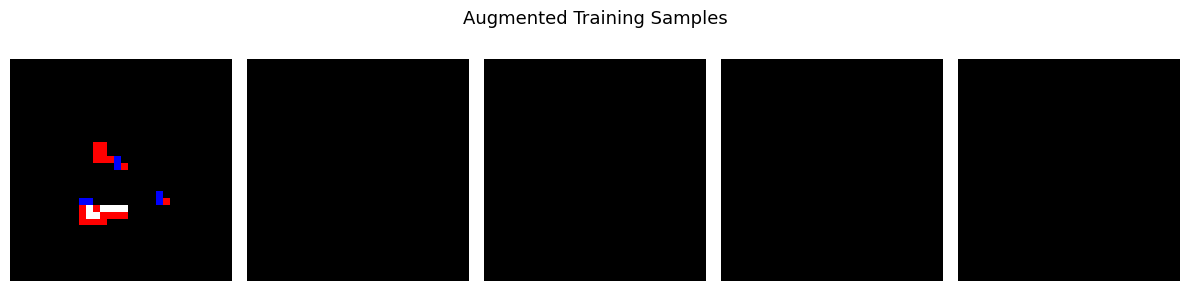

90198

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,     # traffic signs are NOT horizontally symmetric
)
train_datagen.fit(X_train)

train_generator = train_datagen.flow(X_train, y_train_cat, batch_size=BATCH_SIZE, seed=SEED)

# Preview augmented images (fewer for low RAM)
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
sample_batch, _ = next(train_generator)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(sample_batch[i])
    ax.axis('off')
plt.suptitle('Augmented Training Samples', fontsize=13)
plt.tight_layout()
plt.show()

del sample_batch
gc.collect()

## 5. Build Lightweight Custom CNN Model

Reduced filter counts (16→32→64) and smaller dense layer (128 units) for low RAM.

In [9]:
def build_custom_cnn_light(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """Lightweight CNN optimized for low RAM devices."""
    model = models.Sequential([
        # Block 1 (reduced filters)
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Lightweight classifier head
        layers.Flatten(),
        layers.Dense(128, activation='relu'),  # Reduced from 512
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax'),
    ])
    return model

clear_memory()
cnn_model = build_custom_cnn_light()
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
cnn_model.summary()
print(f"\n✓ Lightweight model: {cnn_model.count_params():,} parameters")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,291 (630.04 KB)

 Trainable params: 160,811 (628.17 KB)

 Non-trainable params: 480 (1.88 KB)


✓ Lightweight model: 161,291 parameters


## 6. Train Custom CNN

In [11]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=4, restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1
)

# Memory-efficient training
gc.collect()

cnn_history = cnn_model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val_cat),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

gc.collect()

Epoch 1/15
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - accuracy: 0.0451 - loss: 4.0857 - val_accuracy: 0.0689 - val_loss: 3.5828 - learning_rate: 0.0010
Epoch 2/15
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 308us/step - accuracy: 0.0000e+00 - loss: 3.5364 - val_accuracy: 0.0686 - val_loss: 3.5838 - learning_rate: 0.0010
Epoch 3/15
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.0577 - loss: 3.5703 - val_accuracy: 0.0914 - val_loss: 3.5651 - learning_rate: 0.0010
Epoch 4/15
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 306us/step - accuracy: 0.1875 - loss: 3.0024 - val_accuracy: 0.0918 - val_loss: 3.5634 - learning_rate: 0.0010
Epoch 5/15
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.0628 - loss: 3.4805 - val_accuracy: 0.0796 - val_loss: 3.5106 - learning_rate: 0.0010
Epoch 6/15
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 314us/step - accuracy: 0.0000e+00 - loss: 3.3689 - val_accuracy: 0.0791 - val_loss: 3.5104 - learning_rate: 0.0010
Epoch 7/15
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step 

744

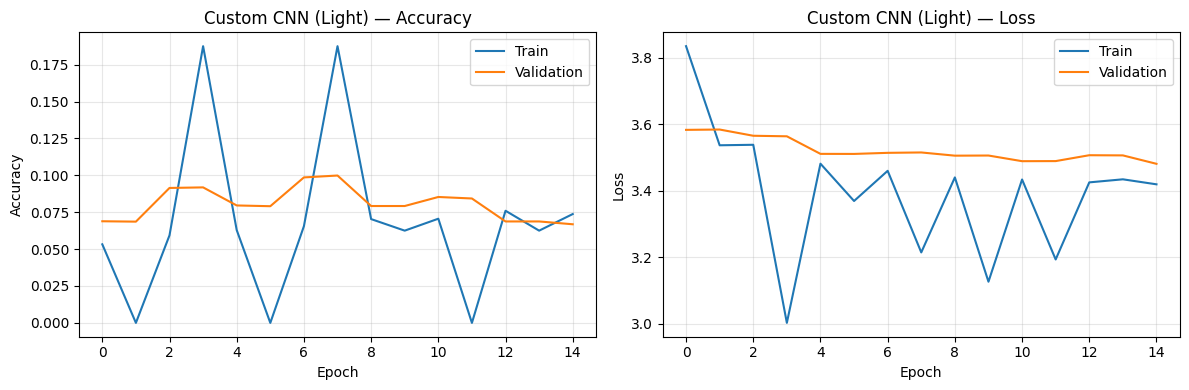

In [12]:
def plot_training_history(history, title=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # Slightly smaller

    # Accuracy
    ax1.plot(history.history['accuracy'],     label='Train')
    ax1.plot(history.history['val_accuracy'],  label='Validation')
    ax1.set_title(f'{title} — Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(history.history['loss'],     label='Train')
    ax2.plot(history.history['val_loss'],  label='Validation')
    ax2.set_title(f'{title} — Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    plt.close()
    gc.collect()

plot_training_history(cnn_history, title='Custom CNN (Light)')

## 7. Evaluate Custom CNN on Test Set

In [13]:
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Custom CNN — Test Accuracy: {cnn_test_acc:.4f}")
print(f"Custom CNN — Test Loss    : {cnn_test_loss:.4f}")

# Predict in batches for low RAM
y_pred_cnn = cnn_model.predict(X_test, batch_size=BATCH_SIZE, verbose=0)
y_pred_cnn = np.argmax(y_pred_cnn, axis=1)

print("\nClassification Report (Custom CNN):")
print(classification_report(y_test, y_pred_cnn, digits=3))

gc.collect()

Custom CNN — Test Accuracy: 0.0641
Custom CNN — Test Loss    : 3.4961

Classification Report (Custom CNN):
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        60
           1      0.000     0.000     0.000       720
           2      0.000     0.000     0.000       750
           3      0.265     0.020     0.037       450
           4      0.000     0.000     0.000       660
           5      0.000     0.000     0.000       630
           6      0.000     0.000     0.000       150
           7      0.000     0.000     0.000       450
           8      0.000     0.000     0.000       450
           9      0.000     0.000     0.000       480
          10      0.000     0.000     0.000       660
          11      0.000     0.000     0.000       420
          12      0.062     0.097     0.076       690
          13      0.065     0.981     0.121       720
          14      0.000     0.000     0.000       270
          15      0.000     

7593

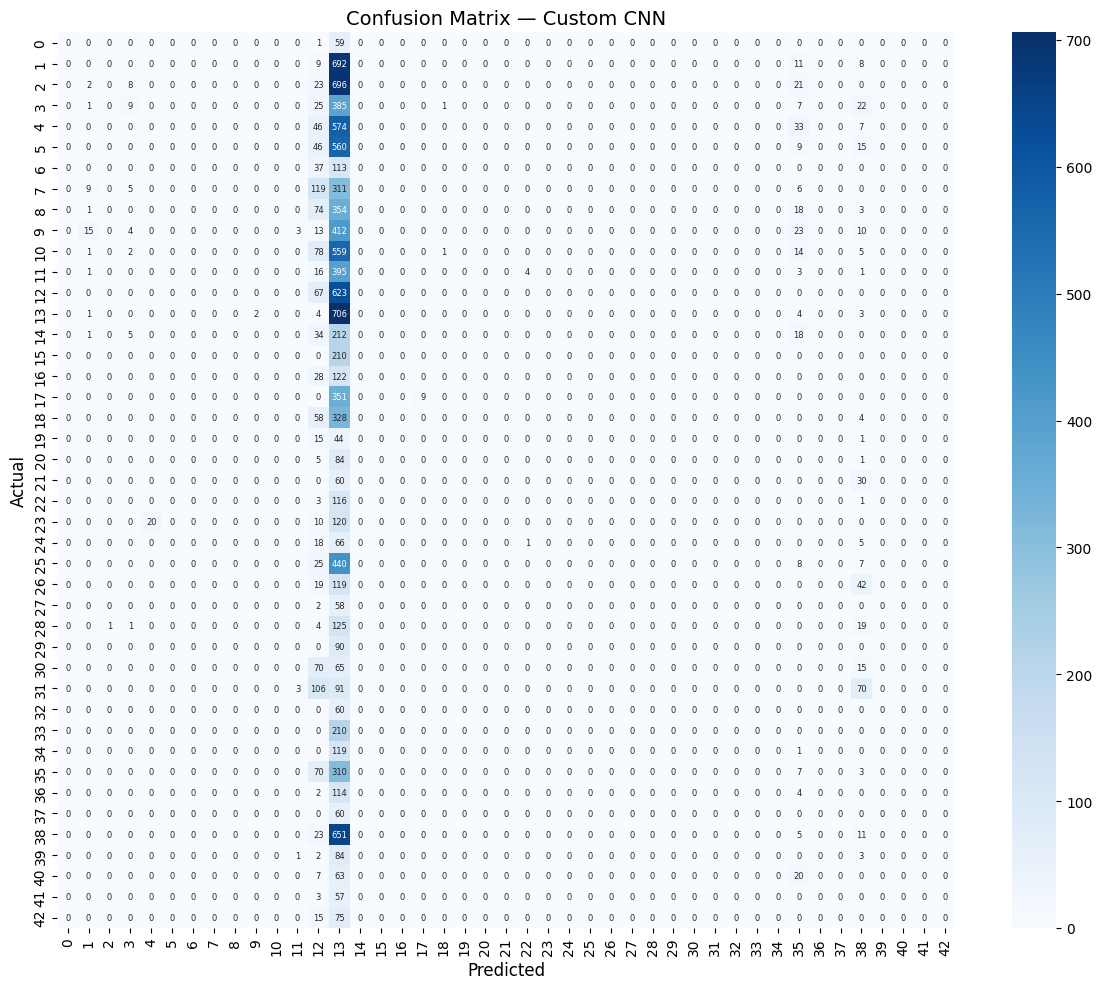

114394

In [15]:
# Confusion Matrix (smaller figure for low RAM)
cm_cnn = confusion_matrix(y_test, y_pred_cnn)

fig, ax = plt.subplots(figsize=(12, 10))  # Reduced size
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES),
            annot_kws={'size': 6})  # Smaller font
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Confusion Matrix — Custom CNN', fontsize=14)
plt.tight_layout()
plt.show()
plt.close()
gc.collect()

## 8. Bonus — Lightweight MobileNetV2 (Transfer Learning)

Using MobileNetV2 with α=0.35 (smallest variant) and 64×64 input for memory efficiency.

In [16]:
# Use smaller image size for MobileNet on low RAM
MOBILE_IMG_SIZE = 64  # Reduced from 96 for memory efficiency

# Process in batches to avoid memory spike
def resize_images_chunked(images, new_size, chunk_size=2000):
    """Resize images in chunks to save memory."""
    resized = []
    total = len(images)
    for start_idx in range(0, total, chunk_size):
        end_idx = min(start_idx + chunk_size, total)
        chunk = images[start_idx:end_idx]
        resized_chunk = np.array([cv2.resize(img, (new_size, new_size)) for img in chunk])
        resized.append(resized_chunk)
        print(f"  Resized {end_idx}/{total}...")
    return np.concatenate(resized, axis=0)

print("Resizing images for MobileNetV2 (chunked)...")
X_train_m = resize_images_chunked(X_train, MOBILE_IMG_SIZE)
gc.collect()
X_val_m = resize_images_chunked(X_val, MOBILE_IMG_SIZE)
gc.collect()
X_test_m = resize_images_chunked(X_test, MOBILE_IMG_SIZE)
gc.collect()

print(f"\nResized train shape: {X_train_m.shape}")
print(f"Resized test shape : {X_test_m.shape}")

Resizing images for MobileNetV2 (chunked)...
  Resized 2000/31367...
  Resized 4000/31367...
  Resized 6000/31367...
  Resized 8000/31367...
  Resized 10000/31367...
  Resized 12000/31367...
  Resized 14000/31367...
  Resized 16000/31367...
  Resized 18000/31367...
  Resized 20000/31367...
  Resized 22000/31367...
  Resized 24000/31367...
  Resized 26000/31367...
  Resized 28000/31367...
  Resized 30000/31367...
  Resized 31367/31367...
  Resized 2000/7842...
  Resized 4000/7842...
  Resized 6000/7842...
  Resized 7842/7842...
  Resized 2000/12630...
  Resized 4000/12630...
  Resized 6000/12630...
  Resized 8000/12630...
  Resized 10000/12630...
  Resized 12000/12630...
  Resized 12630/12630...

Resized train shape: (31367, 64, 64, 3)
Resized test shape : (12630, 64, 64, 3)


In [17]:
def build_mobilenet_light(input_shape=(MOBILE_IMG_SIZE, MOBILE_IMG_SIZE, 3), num_classes=NUM_CLASSES):
    """Lightweight MobileNetV2 using alpha=0.35 for reduced parameters."""
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        alpha=0.35  # Use smallest MobileNetV2 variant for low RAM
    )
    # Freeze base layers
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),  # Reduced from 256
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax'),
    ])
    return model

clear_memory()
mobile_model = build_mobilenet_light()
mobile_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
mobile_model.summary()
print(f"\n✓ Lightweight MobileNetV2: {mobile_model.count_params():,} parameters")

2019640/2019640 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_0.35_224            │ (None, 2, 2, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │         2,795 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 495,243 (1.89 MB)

 Trainable params: 84,907 (331.67 KB)

 Non-trainable params: 410,336 (1.57 MB)


✓ Lightweight MobileNetV2: 495,243 parameters


In [19]:
# Data augmentation for MobileNet input
mobile_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,
)
mobile_datagen.fit(X_train_m)
mobile_generator = mobile_datagen.flow(X_train_m, y_train_cat, batch_size=BATCH_SIZE, seed=SEED)

gc.collect()

# Phase 1: Train head only (fewer epochs for low RAM)
mobile_history_1 = mobile_model.fit(
    mobile_generator,
    steps_per_epoch=len(X_train_m) // BATCH_SIZE,
    epochs=8,  # Reduced from 10
    validation_data=(X_val_m, y_val_cat),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

gc.collect()
print("\n✓ Phase 1 complete (frozen base).")

Epoch 1/8
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 103s 44ms/step - accuracy: 0.0500 - loss: 3.7906 - val_accuracy: 0.0579 - val_loss: 9.2045 - learning_rate: 0.0010
Epoch 2/8
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0000e+00 - loss: 3.4650 - val_accuracy: 0.0580 - val_loss: 9.2063 - learning_rate: 0.0010
Epoch 3/8
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 99s 29ms/step - accuracy: 0.0612 - loss: 3.4971 - val_accuracy: 0.0829 - val_loss: 5.9269 - learning_rate: 0.0010
Epoch 4/8
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 719us/step - accuracy: 0.0000e+00 - loss: 3.2104 - val_accuracy: 0.0829 - val_loss: 5.9278 - learning_rate: 0.0010
Epoch 5/8
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 78s 28ms/step - accuracy: 0.0642 - loss: 3.4638 - val_accuracy: 0.0798 - val_loss: 5.5715 - learning_rate: 0.0010
Epoch 6/8
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - accuracy: 0.1875 - loss: 3.3450 - val_accuracy: 0.0794 - val_loss: 5.5709 - learning_rate: 0.0010
Epoch 7/8
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 56s 29ms/step - accura

In [21]:
# Phase 2: Fine-tune — unfreeze fewer layers for low RAM
base = mobile_model.layers[0]
base.trainable = True

# Freeze all but last 15 layers (reduced from 30 for memory)
for layer in base.layers[:-15]:
    layer.trainable = False

mobile_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

gc.collect()

mobile_history_2 = mobile_model.fit(
    mobile_generator,
    steps_per_epoch=len(X_train_m) // BATCH_SIZE,
    epochs=8,  # Reduced from 10
    validation_data=(X_val_m, y_val_cat),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

gc.collect()
print("\n✓ Phase 2 complete (fine-tuned).")

Epoch 1/8
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 85s 35ms/step - accuracy: 0.0629 - loss: 3.4934 - val_accuracy: 0.0820 - val_loss: 3.7761 - learning_rate: 1.0000e-04
Epoch 2/8
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0625 - loss: 3.4976 - val_accuracy: 0.0825 - val_loss: 3.7762 - learning_rate: 1.0000e-04
Epoch 3/8
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0660 - loss: 3.4625
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 56s 29ms/step - accuracy: 0.0660 - loss: 3.4625 - val_accuracy: 0.0807 - val_loss: 3.9205 - learning_rate: 1.0000e-04
Epoch 4/8
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.0000e+00 - loss: 3.5268 - val_accuracy: 0.0808 - val_loss: 3.9240 - learning_rate: 5.0000e-05
Epoch 5/8
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0640 - loss: 3.4698
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
1960/1960 ━━━━━━━━━━━━━━━━━━━━ 58s 30ms/step

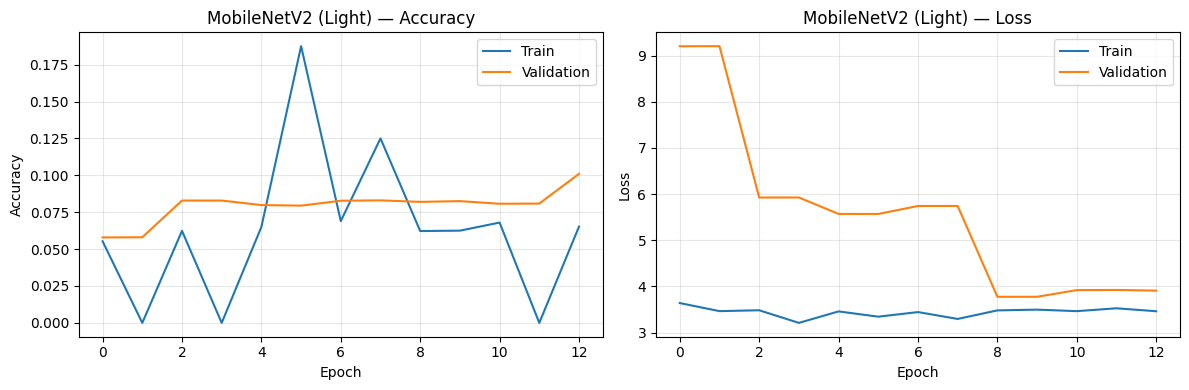

7264

In [22]:
# Combine histories for plotting
combined_history = {}
for key in mobile_history_1.history:
    combined_history[key] = mobile_history_1.history[key] + mobile_history_2.history[key]

class CombinedHistory:
    def __init__(self, h): self.history = h

plot_training_history(CombinedHistory(combined_history), title='MobileNetV2 (Light)')
gc.collect()

## 9. Evaluate MobileNetV2 on Test Set

In [23]:
mob_test_loss, mob_test_acc = mobile_model.evaluate(X_test_m, y_test_cat, verbose=0)
print(f"MobileNetV2 — Test Accuracy: {mob_test_acc:.4f}")
print(f"MobileNetV2 — Test Loss    : {mob_test_loss:.4f}")

# Predict in batches for low RAM
y_pred_mob = mobile_model.predict(X_test_m, batch_size=BATCH_SIZE, verbose=0)
y_pred_mob = np.argmax(y_pred_mob, axis=1)

print("\nClassification Report (MobileNetV2):")
print(classification_report(y_test, y_pred_mob, digits=3))

gc.collect()

MobileNetV2 — Test Accuracy: 0.0835
MobileNetV2 — Test Loss    : 3.7700

Classification Report (MobileNetV2):
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        60
           1      0.032     0.006     0.009       720
           2      0.097     0.685     0.170       750
           3      0.069     0.022     0.034       450
           4      0.026     0.038     0.031       660
           5      0.033     0.008     0.013       630
           6      0.024     0.007     0.010       150
           7      0.068     0.007     0.012       450
           8      0.000     0.000     0.000       450
           9      0.021     0.002     0.004       480
          10      0.075     0.085     0.080       660
          11      0.000     0.000     0.000       420
          12      0.096     0.071     0.082       690
          13      0.253     0.322     0.283       720
          14      0.000     0.000     0.000       270
          15      0.000  

331

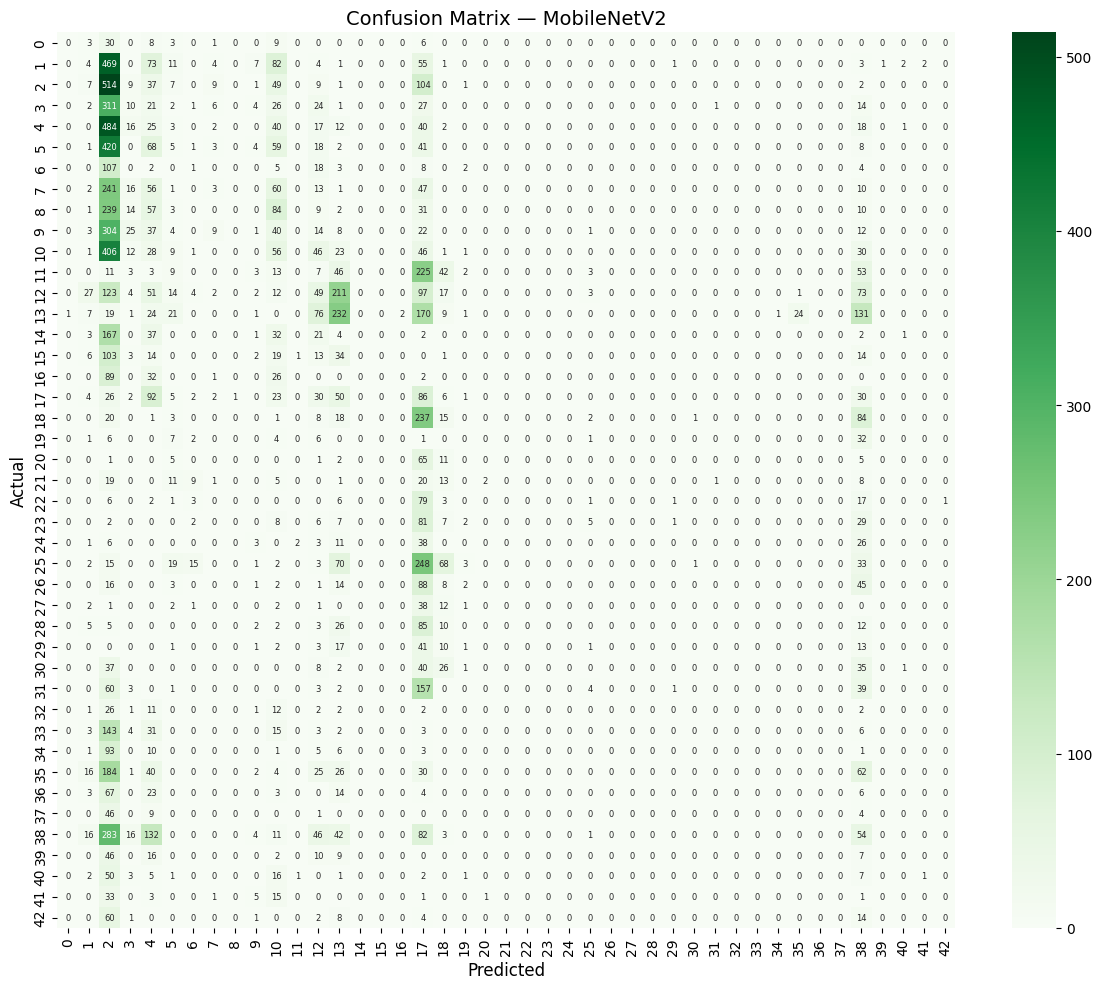

9

In [24]:
# Confusion Matrix — MobileNetV2 (smaller figure for low RAM)
cm_mob = confusion_matrix(y_test, y_pred_mob)

fig, ax = plt.subplots(figsize=(12, 10))  # Reduced size
sns.heatmap(cm_mob, annot=True, fmt='d', cmap='Greens', ax=ax,
            xticklabels=range(NUM_CLASSES), yticklabels=range(NUM_CLASSES),
            annot_kws={'size': 6})  # Smaller font
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Confusion Matrix — MobileNetV2', fontsize=14)
plt.tight_layout()
plt.show()
plt.close()
gc.collect()

## 10. Comparison — Custom CNN vs. MobileNetV2

In [25]:
# Side-by-side comparison
comparison = pd.DataFrame({
    'Model': ['Custom CNN (Light)', 'MobileNetV2 (Light)'],
    'Test Accuracy': [cnn_test_acc, mob_test_acc],
    'Test Loss':     [cnn_test_loss, mob_test_loss],
    'Parameters':    [cnn_model.count_params(), mobile_model.count_params()],
})
comparison['Test Accuracy'] = comparison['Test Accuracy'].map('{:.4f}'.format)
comparison['Test Loss']     = comparison['Test Loss'].map('{:.4f}'.format)
comparison['Parameters']    = comparison['Parameters'].map('{:,}'.format)

print("=" * 70)
print("         MODEL COMPARISON (Low RAM Edition)")
print("=" * 70)
print(comparison.to_string(index=False))
print("=" * 70)

# Memory cleanup after comparison
gc.collect()
print("\n✓ Final memory cleanup complete")

         MODEL COMPARISON (Low RAM Edition)
              Model Test Accuracy Test Loss Parameters
 Custom CNN (Light)        0.0641    3.4961    161,291
MobileNetV2 (Light)        0.0835    3.7700    495,243

✓ Final memory cleanup complete


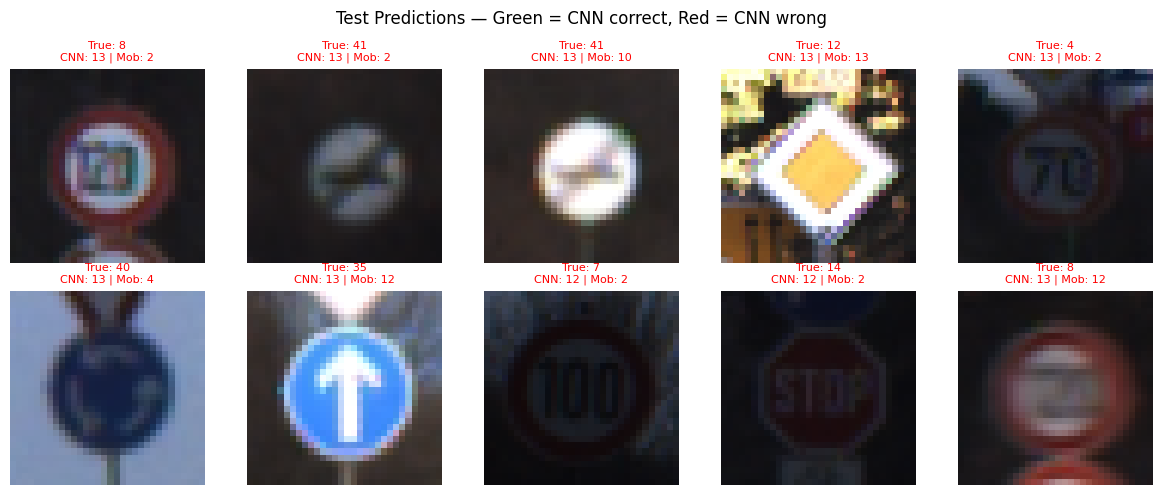

114286

In [26]:
# Visualise some test predictions (both models) - reduced for low RAM
fig, axes = plt.subplots(2, 5, figsize=(12, 5))  # Reduced from 3x5
indices = np.random.choice(len(X_test), 10, replace=False)

for i, ax in enumerate(axes.flatten()):
    idx = indices[i]
    ax.imshow(X_test[idx])
    true_label = y_test[idx]
    cnn_pred   = y_pred_cnn[idx]
    mob_pred   = y_pred_mob[idx]

    colour = 'green' if cnn_pred == true_label else 'red'
    ax.set_title(
        f'True: {true_label}\nCNN: {cnn_pred} | Mob: {mob_pred}',
        fontsize=8, color=colour
    )
    ax.axis('off')

plt.suptitle('Test Predictions — Green = CNN correct, Red = CNN wrong', fontsize=12)
plt.tight_layout()
plt.show()

gc.collect()

## 11. Per-Class Accuracy Comparison

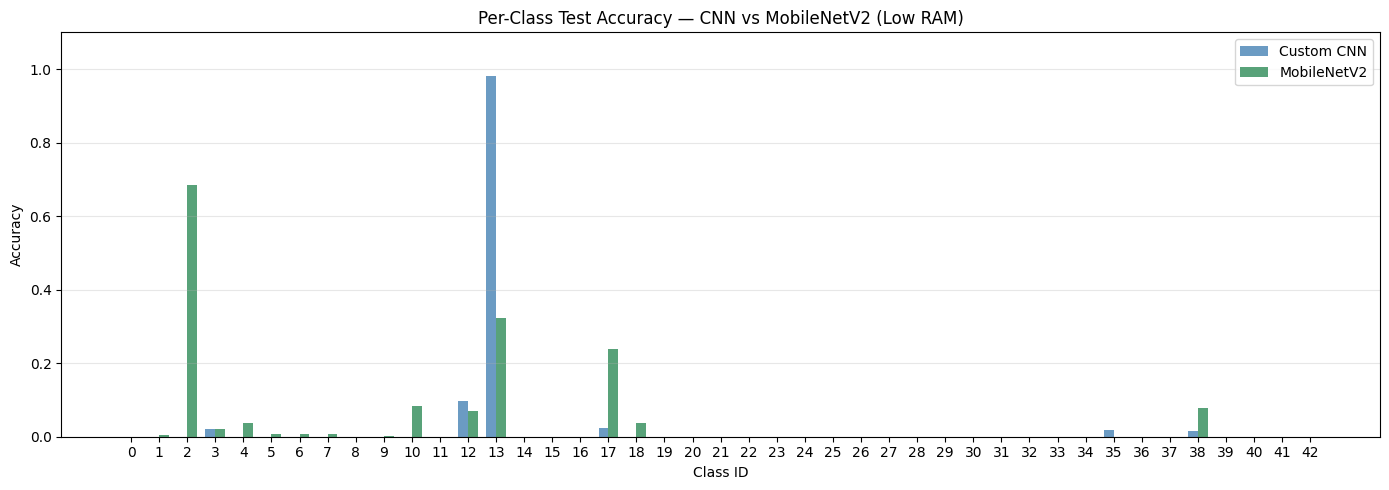

Top-5 hardest classes (CNN)       : [0 1 2 4 6] — acc: [0. 0. 0. 0. 0.]
Top-5 hardest classes (MobileNet) : [ 0 14 11  8 15] — acc: [0. 0. 0. 0. 0.]

✓ Notebook execution complete


In [28]:
# Per-class accuracy for both models
cnn_per_class = cm_cnn.diagonal() / cm_cnn.sum(axis=1)
mob_per_class = cm_mob.diagonal() / cm_mob.sum(axis=1)

fig, ax = plt.subplots(figsize=(14, 5))  # Slightly smaller
x = np.arange(NUM_CLASSES)
width = 0.35

bars1 = ax.bar(x - width/2, cnn_per_class, width, label='Custom CNN', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, mob_per_class, width, label='MobileNetV2', color='seagreen', alpha=0.8)

ax.set_xlabel('Class ID')
ax.set_ylabel('Accuracy')
ax.set_title('Per-Class Test Accuracy — CNN vs MobileNetV2 (Low RAM)')
ax.set_xticks(x)
ax.set_ylim(0, 1.1)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Worst classes for each model
worst_cnn = np.argsort(cnn_per_class)[:5]
worst_mob = np.argsort(mob_per_class)[:5]
print(f"Top-5 hardest classes (CNN)       : {worst_cnn} — acc: {cnn_per_class[worst_cnn].round(3)}")
print(f"Top-5 hardest classes (MobileNet) : {worst_mob} — acc: {mob_per_class[worst_mob].round(3)}")

# Final cleanup
gc.collect()
print("\n✓ Notebook execution complete")